In [9]:
import climakitae as ck
from climakitae.core.data_interface import get_data, get_data_options
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box
from matplotlib.colors import BoundaryNorm
import matplotlib.cm as cm

try:
    from IPython.display import display
except ImportError:
    display = print("why is Ipyon not working")

mojaveShapeRelativePath = "../data/Mojave_National_Preserve.shp"

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    isCartopyAvailable = True
except ImportError:
    print("fix cartopy")
    ccrs = None
    isCartopyAvailable = False

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 150

standardCoordinateReferenceSystem = "EPSG:4326"
analysisVariablesDictionary = {"temp": "Air Temperature at 2m", "precip": "Precipitation (total)"}
dataSpatialResolution = "3 km"
historicalSimulationEndYear = 2014

outputImageDirectory = "OutputImages"
os.makedirs(outputImageDirectory, exist_ok=True)
print(f"output directory: {outputImageDirectory}")

diagnosticAnalysisTimeSpan = (1990, 2030)
diagnosticAnalysisScenarios = ["Historical Climate", "SSP 3-7.0", "SSP 2-4.5"]
mainAnalysisScenarios = ["Historical Climate", "SSP 3-7.0"]

baselinePeriodDefinition = {"name": "Baseline (1985-2014)", "years": (1985, 2014)}
futurePeriodDefinition = {"name": "Late-Century (2071-2100)", "years": (2071, 2100)}
mainAnalysisTimeSpan = (baselinePeriodDefinition["years"][0], futurePeriodDefinition["years"][1])

testScenariosList = ["Historical Climate", "SSP 1-2.6", "SSP 2-4.5", "SSP 3-7.0", "SSP 5-8.5"]
testResolutionsList = ["3 km", "6 km", "45 km"]
testTimeSliceFuture = (2050, 2050)
testTimeSliceHistorical = (1990, 1990)

print("all configuration parameters defined.")


output directory: OutputImages
all configuration parameters defined.


could not load shapefile from ../JoshuaTreeOutlines/JoshuaTree/Joshua_Tree_National_Park.shp: ../JoshuaTreeOutlines/JoshuaTree/Joshua_Tree_National_Park.shp: No such file or directory
using fallback bounding box.
mojave boundary loaded. lat (np.float64(34.71693048361919), np.float64(35.59077455259237)), lon (np.float64(-116.16503220167623), np.float64(-114.94916062294271))


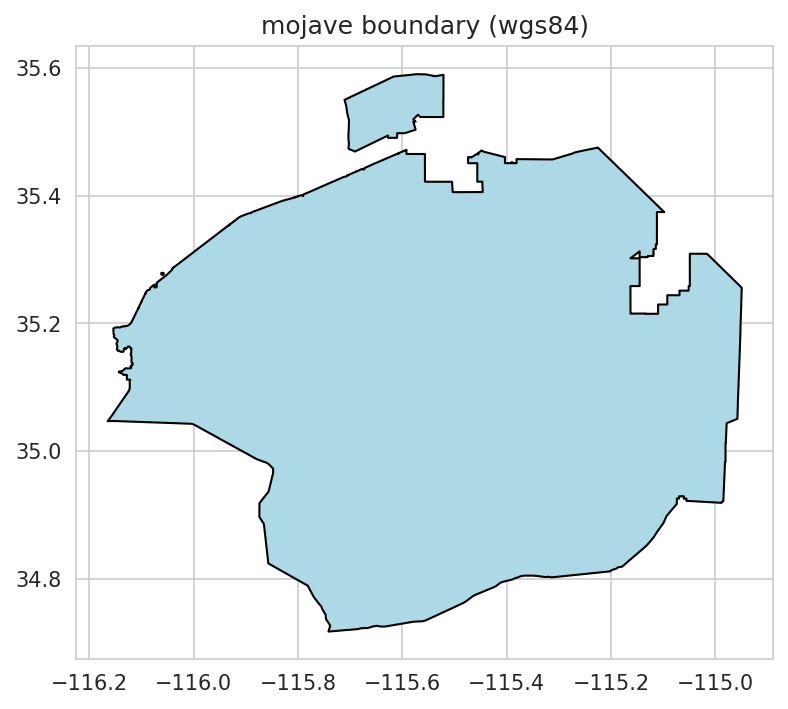

In [10]:
try:
    joshuaTreeBoundaryWgs84 = gpd.read_file(joshuaTreeShapeRelativePath)
    if joshuaTreeBoundaryWgs84.crs is None:
        joshuaTreeBoundaryWgs84.set_crs(standardCoordinateReferenceSystem, inplace=True)
        print("jtree crs is wgs84")
    elif str(joshuaTreeBoundaryWgs84.crs) != standardCoordinateReferenceSystem:
        joshuaTreeBoundaryWgs84 = joshuaTreeBoundaryWgs84.to_crs(standardCoordinateReferenceSystem)

    boundaryBounds = joshuaTreeBoundaryWgs84.total_bounds
    jtreeLongitudeSlice = (boundaryBounds[0], boundaryBounds[2])
    jtreeLatitudeSlice = (boundaryBounds[1], boundaryBounds[3])
    print(f"jtree boundary loaded. lat {jtreeLatitudeSlice}, lon {jtreeLongitudeSlice}")

    joshuaTreeBoundaryWgs84.plot(figsize=(6, 6), edgecolor="black", facecolor="lightblue")
    plt.title("jtree boundary (wgs84)")
    plt.show()

except Exception as e:
    print(f"could not load shapefile from {joshuaTreeShapeRelativePath}: {e}")
    print("using fallback bounding box.")
    joshuaTreeBoundaryWgs84 = None
    jtreeLongitudeSlice = (-116.6, -115.4)
    jtreeLatitudeSlice = (33.5, 34.3)

try:
    mojaveBoundaryWgs84 = gpd.read_file(mojaveShapeRelativePath)
    if mojaveBoundaryWgs84.crs is None:
        mojaveBoundaryWgs84.set_crs(standardCoordinateReferenceSystem, inplace=True)
        print("mojave crs is wgs84")
    elif str(mojaveBoundaryWgs84.crs) != standardCoordinateReferenceSystem:
        mojaveBoundaryWgs84 = mojaveBoundaryWgs84.to_crs(standardCoordinateReferenceSystem)

    boundaryBounds = mojaveBoundaryWgs84.total_bounds
    mojaveLongitudeSlice = (boundaryBounds[0], boundaryBounds[2])
    mojaveLatitudeSlice = (boundaryBounds[1], boundaryBounds[3])
    print(f"mojave boundary loaded. lat {mojaveLatitudeSlice}, lon {mojaveLongitudeSlice}")

    mojaveBoundaryWgs84.plot(figsize=(6, 6), edgecolor="black", facecolor="lightblue")
    plt.title("mojave boundary (wgs84)")
    plt.show()

except Exception as e:
    print(f"could not load shapefile from {mojaveShapeRelativePath}: {e}")
    print("using fallback bounding box.")
    mojaveBoundaryWgs84 = None
    mojaveLongitudeSlice = (-116.6, -114.4)
    mojaveLatitudeSlice = (34.5, 36.5)

In [14]:
def convertDataUnits(dataArray, variableKey):
    processedDataArray = dataArray.copy()
    if variableKey == "temp" and processedDataArray.attrs.get("units") == "K":
        processedDataArray = processedDataArray - 273.15
        processedDataArray.attrs["units"] = "°C"
    elif variableKey == "precip" and processedDataArray.attrs.get("units") in ["kg/m^2/s", "kg m-2 s-1"]:
        daysInMonth = processedDataArray.time.dt.days_in_month
        secondsPerDay = 86400
        processedDataArray = (processedDataArray * secondsPerDay) * daysInMonth
        processedDataArray.attrs["units"] = "mm/month"
    return processedDataArray


def maskDataArrayToBoundary(dataArray, boundaryGdfWgs84):
    if dataArray is None or boundaryGdfWgs84 is None:
        return dataArray
    dataCrs = dataArray.rio.crs
    if dataCrs is None:
        print("raster doesnt have crs. cant mask.")
        return dataArray
    try:
        if str(dataCrs) != str(boundaryGdfWgs84.crs):
            boundaryNativeCrs = boundaryGdfWgs84.to_crs(dataCrs)
        else:
            boundaryNativeCrs = boundaryGdfWgs84
    except Exception:
        return dataArray
    try:
        coordsToDrop = ["lon", "landmask", "lakemask"]
        dataCleaned = dataArray.drop_vars(coordsToDrop, errors="ignore")
        try:
            spatialDims = (dataCleaned.rio.y_dim, dataCleaned.rio.x_dim)
        except Exception:
            if "y" in dataCleaned.dims and "x" in dataCleaned.dims:
                spatialDims = ("y", "x")
            else:
                return dataArray
        nonSPatialDimenosn = [dim for dim in dataCleaned.dims if dim not in spatialDims]
        expectedOrder = tuple(nonSPatialDimenosn) + spatialDims
        if dataCleaned.dims != expectedOrder:
            dataCleaned = dataCleaned.transpose(*expectedOrder)
    except Exception:
        dataCleaned = dataArray
    try:
        maskedDataArray = dataCleaned.rio.clip(boundaryNativeCrs.geometry.values, drop=False, all_touched=True)
        maskedDataArray.attrs.update(dataArray.attrs)
        return maskedDataArray
    except Exception as e:
        print(f"error with masking {e}")
        return dataCleaned


def reprojectAndClipDataArray(dataArray, boundaryGdfWgs84):
    if dataArray is None or boundaryGdfWgs84 is None:
        return None
    dataCrs = dataArray.rio.crs
    reprojectedData = dataArray
    if dataCrs is not None and str(dataCrs) != standardCoordinateReferenceSystem:
        try:
            coordsToDrop = ["lon", "landmask", "lakemask"]
            dataCleaned = dataArray.drop_vars(coordsToDrop, errors="ignore")
            try:
                spatialDims = (dataCleaned.rio.y_dim, dataCleaned.rio.x_dim)
            except Exception:
                if "y" in dataCleaned.dims and "x" in dataCleaned.dims:
                    spatialDims = ("y", "x")
                else:
                    return dataArray
            nonSpatialDims = [dim for dim in dataCleaned.dims if dim not in spatialDims]
            expectedOrder = tuple(nonSpatialDims) + spatialDims
            if dataCleaned.dims != expectedOrder:
                dataCleaned = dataCleaned.transpose(*expectedOrder)
            reprojectedData = dataCleaned.rio.reproject(standardCoordinateReferenceSystem)
        except Exception as e:
            print(f"error during reprojection: {e}")
            return None
    try:
        clippedData = reprojectedData.rio.clip(boundaryGdfWgs84.geometry.values, drop=True, all_touched=True)
        clippedData.attrs.update(dataArray.attrs)
        return clippedData
    except Exception as e:
        print(f"error during clipping: {e}")
        return None


def diagnoseSpatialWeights(maskedDataArray):
    if maskedDataArray is None:
        return None
    if "lat" not in maskedDataArray.coords:
        print(f"skipping spatial weights for {maskedDataArray.name}: lat missing.")
        return None
    weightsInitial = np.cos(np.deg2rad(maskedDataArray.lat))
    yDim = maskedDataArray.rio.y_dim or "y"
    xDim = maskedDataArray.rio.x_dim or "x"
    nonSpatialDims = [dim for dim in maskedDataArray.dims if dim not in [yDim, xDim]]
    if nonSpatialDims:
        isInsideBoundary = maskedDataArray.notnull().any(dim=nonSpatialDims)
    else:
        isInsideBoundary = maskedDataArray.notnull()
    weightsMasked = weightsInitial.where(isInsideBoundary)
    weightsFinal = weightsMasked.fillna(0)
    return weightsFinal


def checkDataQuality(dataArray, variableKey):
    if dataArray is None:
        return
    print(f"performing data quality checks on {variableKey} (first year subset)")
    try:
        subsetData = dataArray.isel(time=slice(0, 12))
        subsetData.load()
    except Exception as e:
        print(f"could not load subset: {e}")
        return
    dataValues = subsetData.values
    nanCount = np.isnan(dataValues).sum()
    print(f"nan check: {nanCount} nans found.")
    infCount = np.isinf(dataValues).sum()
    print(f"infinity check: {infCount} infinite values found.")
    try:
        minValue, maxValue = np.nanmin(dataValues), np.nanmax(dataValues)
        dataUnits = dataArray.attrs.get("units")
        print(f"value range: min {minValue:.4f}, max {maxValue:.4f} {dataUnits}")
        if variableKey == "temp":
            if dataUnits == "°C" and (minValue < -50 or maxValue > 60):
                print("warning: unrealistic temperatures (°c).")
            elif dataUnits == "K" and (minValue < 223 or maxValue > 333):
                print("warning: unrealistic temperatures (k).")
        elif variableKey == "precip" and minValue < 0:
            print("warning: negative precipitation values.")
    except Exception as e:
        print(f"could not determine range: {e}")


def calculateSpatialAverage(maskedDataArray, spatialWeights):
    if maskedDataArray is None:
        return None
    try:
        xDim, yDim = maskedDataArray.rio.x_dim, maskedDataArray.rio.y_dim
        if spatialWeights is not None:
            try:
                spatialAverage = maskedDataArray.weighted(spatialWeights).mean(dim=[xDim, yDim], skipna=True)
            except Exception as e:
                print(f"weight failure: {e}. falling back to unweighted mean.")
                spatialAverage = maskedDataArray.mean(dim=[xDim, yDim], skipna=True)
        else:
            spatialAverage = maskedDataArray.mean(dim=[xDim, yDim], skipna=True)
        spatialAverage.load()
        if spatialAverage.isnull().all():
            print("warning: spatial average all null.")
            return None
        return spatialAverage
    except Exception as e:
        print(f"error calculating spatial average: {e}")
        return None


def aggregateDataAnnually(spatialAverageData, variableKey):
    if spatialAverageData is None:
        return None
    print(f"aggregate data annually for {variableKey}")
    if variableKey == "precip":
        annualData = spatialAverageData.resample(time="YE").sum(dim="time", skipna=True)
        annualData.attrs["units"] = "mm/year"
    else:
        annualData = spatialAverageData.resample(time="YE").mean(dim="time", skipna=True)
        annualData.attrs["units"] = spatialAverageData.attrs.get("units", "°C")
    return annualData


def plotAnnualSpread(annualData, variableKey):
    if annualData is None:
        return
    dataFrame = annualData.to_dataframe(name="Value").reset_index()
    if "time" not in dataFrame.columns:
        return
    dataFrame["Year"] = dataFrame["time"].dt.year
    if "scenario" in dataFrame.columns:
        stringToRemove = "Historical +"
        sspName = dataFrame["scenario"].astype(str).str.replace(stringToRemove, "", regex=False).str.strip()
        dataFrame["ScenarioAdjusted"] = np.where(dataFrame["Year"] <= historicalSimulationEndYear, "Historical Climate", sspName)
        dataFrame.loc[dataFrame["scenario"] == "Historical Climate", "ScenarioAdjusted"] = "Historical Climate"
    else:
        dataFrame["ScenarioAdjusted"] = "Unknown Scenario"
    plt.figure(figsize=(14, 7))
    if "simulation" in dataFrame.columns:
        sns.lineplot(data=dataFrame, x="Year", y="Value", hue="ScenarioAdjusted", units="simulation", estimator=None, alpha=0.2, linewidth=0.5)
    sns.lineplot(data=dataFrame, x="Year", y="Value", hue="ScenarioAdjusted", linewidth=3, errorbar=None)
    plt.title(f"annual {analysisVariablesDictionary.get(variableKey, variableKey)} spread and ensemble mean")
    plt.ylabel(f"value ({annualData.attrs.get('units', '')})")
    plt.axvline(x=historicalSimulationEndYear + 0.5, color="k", linestyle="--", linewidth=1, label=f"end of historical ({historicalSimulationEndYear})")
    plotHandles, plotLabels = plt.gca().get_legend_handles_labels()
    uniqueScenarioLabels = dataFrame["ScenarioAdjusted"].unique()
    finalHandles = []
    finalLabels = []
    for handle, label in zip(plotHandles, plotLabels):
        if label in uniqueScenarioLabels and handle.get_linewidth() == 3:
            if label not in finalLabels:
                finalHandles.append(handle)
                finalLabels.append(label)
    for handle, label in zip(plotHandles, plotLabels):
        if "end of historical" in label.lower():
            finalHandles.append(handle)
            finalLabels.append(label)
            break
    plt.legend(handles=finalHandles, labels=finalLabels, title="scenario / event")
    plt.grid(True)
    plt.show()


def plotSimulationDistribution(annualData, variableKey, yearsToCheckList):
    if annualData is None:
        return
    dataToPlotList = []
    for year in yearsToCheckList:
        try:
            yearData = annualData.sel(time=f"{year}-12-31")
            dataFrame = yearData.to_dataframe(name="value").reset_index()
            dataFrame["Year"] = str(year)
            if "scenario" in dataFrame.columns:
                if year > historicalSimulationEndYear:
                    dataFrame["Scenario"] = dataFrame["scenario"].str.replace("Historical +", "", regex=False).str.strip()
                else:
                    dataFrame["Scenario"] = "Historical"
            else:
                dataFrame["Scenario"] = "Unknown"
            dataToPlotList.append(dataFrame)
        except KeyError:
            print(f"year {year} not found.")
            continue
    if not dataToPlotList:
        print("no data for queried years.")
        return
    dataFrameCombined = pd.concat(dataToPlotList)
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=dataFrameCombined, x="Year", y="value", hue="Scenario", palette="coolwarm", inner="point", dodge=True)
    plt.title(f"distribution of annual {variableKey} across simulations")
    plt.ylabel(annualData.attrs.get("units"))
    plt.grid(True, axis="y", linestyle=":")
    plt.show()


def plotSeasonalComparison(spatialAverageDataDictionary, variableKey):
    if variableKey not in spatialAverageDataDictionary or spatialAverageDataDictionary[variableKey] is None:
        return
    data = spatialAverageDataDictionary[variableKey]
    baselinePeriod = (diagnosticAnalysisTimeSpan[0], historicalSimulationEndYear)
    futurePeriod = (historicalSimulationEndYear + 1, diagnosticAnalysisTimeSpan[1])
    baselineData = data.sel(time=slice(str(baselinePeriod[0]), str(baselinePeriod[1])))
    futureData = data.sel(time=slice(str(futurePeriod[0]), str(futurePeriod[1])))
    baselineClimatology = baselineData.groupby("time.month").mean(dim="time")
    futureClimatology = futureData.groupby("time.month").mean(dim="time")
    dataFrameBase = baselineClimatology.to_dataframe(name=variableKey).reset_index()
    dataFrameFuture = futureClimatology.to_dataframe(name=variableKey).reset_index()
    if "scenario" in dataFrameFuture.columns:
        dataFrameFuture["scenario"] = dataFrameFuture["scenario"].str.replace("Historical + ", "", regex=False).str.strip()
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dataFrameBase, x="month", y=variableKey, label=f"baseline ({baselinePeriod[0]}-{baselinePeriod[1]})", color="black", estimator="mean", errorbar="sd", linewidth=2)
    if "scenario" in dataFrameFuture.columns:
        sns.lineplot(data=dataFrameFuture, x="month", y=variableKey, hue="scenario", estimator="mean", errorbar="sd", linewidth=2)
    else:
        sns.lineplot(data=dataFrameFuture, x="month", y=variableKey, label=f"future ({futurePeriod[0]}-{futurePeriod[1]})", estimator="mean", errorbar="sd", linewidth=2, color="red")
    plt.title(f"seasonal cycle comparison: {analysisVariablesDictionary.get(variableKey, variableKey)}")
    plt.ylabel(f"{variableKey} ({data.attrs.get('units', '')})")
    plt.xlabel("month")
    plt.xticks(range(1, 13))
    plt.legend(title="period/scenario (mean +/- 1 sd)")
    plt.grid(True)
    plt.show()


def analyzeSpatialVariability(maskedDataArray, variableKey):
    if maskedDataArray is None:
        return
    try:
        xDim = maskedDataArray.rio.x_dim
        yDim = maskedDataArray.rio.y_dim
        spatialStdDev = maskedDataArray.std(dim=[xDim, yDim], skipna=True)
        spatialStdDev.load()
    except Exception as e:
        print(f"error calculating spatial std: {e}")
        return
    annualSpatialStdDev = spatialStdDev.resample(time="YE").mean(dim="time")
    dataframe = annualSpatialStdDev.to_dataframe(name="Spatial_STD").reset_index()
    if "time" not in dataframe.columns:
        return
    dataframe["Year"] = dataframe["time"].dt.year
    if "scenario" in dataframe.columns:
        sspName = dataframe["scenario"].str.replace("Historical +", "", regex=False).str.strip()
        dataframe["Scenario_Adjusted"] = np.where(dataframe["Year"] <= historicalSimulationEndYear, "Historical Climate", sspName)
        dataframe.loc[dataframe["scenario"] == "Historical Climate", "Scenario_Adjusted"] = "Historical Climate"
    else:
        dataframe["Scenario_Adjusted"] = "Unknown Scenario"
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=dataframe, x="Year", y="Spatial_STD", hue="Scenario_Adjusted", estimator="mean")
    plt.title(f"average annual spatial std within boundary ({variableKey})")
    plt.ylabel(f"spatial std ({maskedDataArray.attrs.get('units')})")
    plt.axvline(x=historicalSimulationEndYear + 0.5, color="k", linestyle="--", linewidth=1)
    plt.grid(True)
    plt.show()


def aggregateAvailabilityStatus(statusSeries):
    if "Failure" in statusSeries.values or "Error" in statusSeries.values:
        return "Unavailable"
    elif "Success" in statusSeries.values:
        return "Available"
    return "N/A"


def styleAvailabilityPivot(value):
    color = "lightgreen" if value == "Available" else "salmon" if value == "Unavailable" else "white"
    return f"background-color: {color}"


def plotDiscretePanel(ax, data, cmapName, title, boundaryGdfWgs84=None, mapProjection=None, plotExtent=None, numBins=8, center=None):
    if hasattr(data.data, "dask"):
        data.load()
    try:
        vmin, vmax = np.nanpercentile(data, [5, 95])
    except Exception:
        return None
    if center is not None:
        vlim = max(abs(vmin), abs(vmax))
        nBins = numBins if numBins % 2 == 0 else numBins + 1
        levels = np.linspace(-vlim, vlim, nBins + 1)
    else:
        levels = np.linspace(vmin, vmax, numBins + 1)
    try:
        cmap = plt.colormaps[cmapName].resampled(len(levels) - 1)
    except Exception:
        try:
            cmap = plt.get_cmap(cmapName, len(levels) - 1)
        except Exception:
            cmap = plt.get_cmap("viridis", len(levels) - 1)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    transform = mapProjection if mapProjection else ax.transData
    mesh = data.plot.pcolormesh(ax=ax, transform=transform, cmap=cmap, norm=norm, add_colorbar=False)
    if plotExtent and mapProjection:
        ax.set_extent(plotExtent, crs=mapProjection)
    if boundaryGdfWgs84 is not None:
        boundaryGdfWgs84.boundary.plot(ax=ax, color="black", linewidth=1.2)
    ax.set_title(title)
    return mesh

In [15]:
try:
    from IPython.display import display
except ImportError:
    display = print("bruh")

for key, variableName in analysisVariablesDictionary.items():
    try:
        rawOptionsDataFrame = get_data_options(variable=variableName)
        print("type:", type(rawOptionsDataFrame))
        if isinstance(rawOptionsDataFrame, pd.DataFrame):
            print("columns found:", rawOptionsDataFrame.columns.tolist())
            print("dataframe head:")
            display(rawOptionsDataFrame.head())
        else:
            print(rawOptionsDataFrame)
    except Exception as e:
        print(f"error w diagnostic: {e}")

type: <class 'pandas.core.frame.DataFrame'>
columns found: ['variable', 'resolution']
dataframe head:


variable  \
downscaling_method scenario           timescale                          
Dynamical          Historical Climate hourly     Air Temperature at 2m   
                                      hourly     Air Temperature at 2m   
                                      hourly     Air Temperature at 2m   
                   SSP 3-7.0          hourly     Air Temperature at 2m   
                                      hourly     Air Temperature at 2m   

                                                resolution  
downscaling_method scenario           timescale             
Dynamical          Historical Climate hourly         45 km  
                                      hourly          9 km  
                                      hourly          3 km  
                   SSP 3-7.0          hourly         45 km  
                                      hourly          9 km

type: <class 'pandas.core.frame.DataFrame'>
columns found: ['variable', 'resolution']
dataframe head:


variable  \
downscaling_method scenario           timescale                          
Statistical        Historical Climate daily      Precipitation (total)   
                                      monthly    Precipitation (total)   
                   SSP 2-4.5          daily      Precipitation (total)   
                                      monthly    Precipitation (total)   
                   SSP 3-7.0          daily      Precipitation (total)   

                                                resolution  
downscaling_method scenario           timescale             
Statistical        Historical Climate daily           3 km  
                                      monthly         3 km  
                   SSP 2-4.5          daily           3 km  
                                      monthly         3 km  
                   SSP 3-7.0          daily           3 km

In [16]:
print("step 1: checking available resolutions broadly.")
isResolutionSupportedDictionary = {}

for key, variableName in analysisVariablesDictionary.items():
    print(f"variable: {variableName} ({key})")
    isResolutionSupportedDictionary[key] = False
    try:
        optionsByVariableDataFrame = get_data_options(variable=variableName)
        if not isinstance(optionsByVariableDataFrame, pd.DataFrame) or "resolution" not in optionsByVariableDataFrame.columns:
            print(f"resolution column missing. found columns: {getattr(optionsByVariableDataFrame, 'columns', 'n/a')}")
            continue

        availableResolutionsList = optionsByVariableDataFrame["resolution"].unique()
        print(f"available resolutions: {sorted(list(availableResolutionsList))}")

        if dataSpatialResolution in availableResolutionsList:
            isResolutionSupportedDictionary[key] = True
            print(f"target resolution {dataSpatialResolution} supported.")
        else:
            print(f"desired resolution {dataSpatialResolution} not available for {key}.")

    except Exception as e:
        print(f"error during resolution check: {e}")

print(f"step 2 and 3: querying detailed options for resolution: {dataSpatialResolution}")

for key, variableName in analysisVariablesDictionary.items():
    print(f"variable: {variableName} ({key}) @ {dataSpatialResolution}")

    if not isResolutionSupportedDictionary.get(key, False):
        print("skip detailed check as resolution is not supported.")
        continue

    try:
        detailedOptionsDataFrame = get_data_options(variable=variableName, resolution=dataSpatialResolution)

        if not isinstance(detailedOptionsDataFrame, pd.DataFrame):
            print(f"expected dataframe but got {type(detailedOptionsDataFrame)}")
            continue

        if "scenario" not in detailedOptionsDataFrame.columns:
            print("detailed metadata still missing for this combo.")
            print(detailedOptionsDataFrame.columns.tolist())
            continue

        subsetDataFrame = detailedOptionsDataFrame.copy()
        timeScaleColumn = None
        if "timescale" in detailedOptionsDataFrame.columns:
            timeScaleColumn = "timescale"
        elif "frequency" in detailedOptionsDataFrame.columns:
            timeScaleColumn = "frequency"

        if timeScaleColumn:
            subsetDataFrame = subsetDataFrame[subsetDataFrame[timeScaleColumn] == "monthly"]

        if subsetDataFrame.empty:
            print("no monthly data for this combo.")
            continue

        simulationIdentifierColumn = None
        for identifier in ["simulation", "source", "model", "source_id"]:
            if identifier in subsetDataFrame.columns:
                simulationIdentifierColumn = identifier
                break

        if simulationIdentifierColumn:
            simulationCountsSeries = subsetDataFrame.groupby("scenario")[simulationIdentifierColumn].nunique().sort_values(ascending=False)
            print(simulationCountsSeries)
        else:
            simulationCountsSeries = subsetDataFrame["scenario"].value_counts().sort_values(ascending=False)
            print(simulationCountsSeries)

    except Exception as e:
        print(f"error retrieving detailed options: {e}")


step 1: checking available resolutions broadly.
variable: Air Temperature at 2m (temp)
available resolutions: ['3 km', '45 km', '9 km']
target resolution 3 km supported.
variable: Precipitation (total) (precip)
available resolutions: ['3 km', '45 km', '9 km']
target resolution 3 km supported.
step 2 and 3: querying detailed options for resolution: 3 km
variable: Air Temperature at 2m (temp) @ 3 km
detailed metadata still missing for this combo.
['variable', 'resolution']
variable: Precipitation (total) (precip) @ 3 km
detailed metadata still missing for this combo.
['variable', 'resolution']


In [17]:
mojaveDiagnosticDataDictionary = {}
mojaveSpatialResolution = "9 km"
mojaveDiagnosticScenarios = ["Historical Climate", "SSP 1-2.6", "SSP 2-4.5", "SSP 3-7.0", "SSP 5-8.5"]

if "mojaveLatitudeSlice" not in globals() or "mojaveLongitudeSlice" not in globals():
    print("mojave slices not defined.")
else:
    print(f"load mojave diagnostic data subset (monthly, {mojaveSpatialResolution}, {diagnosticAnalysisTimeSpan})...")
    for key, variableName in analysisVariablesDictionary.items():
        print(f"retrieving mojave {key}...")
        try:
            data = get_data(
                variable=variableName,
                resolution=mojaveSpatialResolution,
                timescale="monthly",
                scenario=mojaveDiagnosticScenarios,
                time_slice=diagnosticAnalysisTimeSpan,
                latitude=mojaveLatitudeSlice,
                longitude=mojaveLongitudeSlice
            )
            if data is not None and hasattr(data, "time") and data.time.size > 0:
                data.name = key
                mojaveDiagnosticDataDictionary[key] = data
                print(f"success. dims {data.dims}, size {data.nbytes / 1e9:.2f} gb (lazy)")
                if "scenario" in data.coords:
                    print(f"scenarios returned: {data.scenario.values}")
            else:
                print(f"no data returned for mojave {key}.")
        except Exception as e:
            print(f"error retrieving mojave {key}: {e}")


load mojave diagnostic data subset (monthly, 9 km, (1990, 2030))...
retrieving mojave temp...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

WARNING
-------
You have retrieved data for more than one SSP, but not all ensemble members for each GCM are available for all SSPs.

As a result, some scenario and simulation combinations may contain NaN values.

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual scenario and then dropping NaN values.
success. dims ('scenario', 'simulation', 'time', 'y', 'x'), size 0.01 gb (lazy)
scenarios returned: ['Historical + SSP 2-4.5' 'Historical + SSP 3-7.0'
 'Historical + SSP 5-8.5']
retrieving mojave precip...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

WARNING
-------
You have retrieved data

In [19]:
processedMojaveDiagnosticData = {}

if not mojaveDiagnosticDataDictionary:
    print("mojave diagnostic data not loaded.")
else:
    for key, data in mojaveDiagnosticDataDictionary.items():
        print(f"processing mojave {key}")
        dataWithConvertedUnits = convertDataUnits(data, key)
        if "mojaveBoundaryWgs84" in globals() and mojaveBoundaryWgs84 is not None:
            maskedDataArray = maskDataArrayToBoundary(dataWithConvertedUnits, mojaveBoundaryWgs84)
        else:
            maskedDataArray = dataWithConvertedUnits

        if maskedDataArray is not None:
            maskedDataArray.name = key
            processedMojaveDiagnosticData[key] = maskedDataArray

processing mojave temp
processing mojave precip


In [20]:
def computeSpatialWeights_noPlot(maskedDataArray):
    if maskedDataArray is None:
        return None
    if "lat" not in maskedDataArray.coords:
        print("skipping weights: lat missing.")
        return None

    weightsInitial = np.cos(np.deg2rad(maskedDataArray.lat))

    yDim = maskedDataArray.rio.y_dim or "y"
    xDim = maskedDataArray.rio.x_dim or "x"
    nonSpatialDims = [dim for dim in maskedDataArray.dims if dim not in [yDim, xDim]]

    if nonSpatialDims:
        isInsideBoundary = maskedDataArray.notnull().any(dim=nonSpatialDims)
    else:
        isInsideBoundary = maskedDataArray.notnull()

    weightsMasked = weightsInitial.where(isInsideBoundary)
    weightsFinal = weightsMasked.fillna(0)
    return weightsFinal


mojaveSpatialWeightsDictionary = {}
mojaveSpatialAverageMonthlyDictionary = {}

if not processedMojaveDiagnosticData:
    print("no processed mojave data.")
else:
    for key, data in processedMojaveDiagnosticData.items():
        print(f"mojave spatial averaging for {key}")
        weights = computeSpatialWeights_noPlot(data)
        mojaveSpatialWeightsDictionary[key] = weights
        spatialAverage = calculateSpatialAverage(data, weights)
        if spatialAverage is not None:
            mojaveSpatialAverageMonthlyDictionary[key] = spatialAverage
            checkDataQuality(spatialAverage, key)

mojave spatial averaging for temp
performing data quality checks on temp (first year subset)
nan check: 168 nans found.
infinity check: 0 infinite values found.
value range: min 1.2968, max 30.2224 °C
mojave spatial averaging for precip
performing data quality checks on precip (first year subset)
nan check: 168 nans found.
infinity check: 0 infinite values found.
value range: min 0.0072, max 133.9041 mm


In [21]:
mojaveAnnualDataDictionary = {}

if not mojaveSpatialAverageMonthlyDictionary:
    print("no mojave spatial averages.")
else:
    for key, spatialAverage in mojaveSpatialAverageMonthlyDictionary.items():
        mojaveAnnualDataDictionary[key] = aggregateDataAnnually(spatialAverage, key)
        print(f"mojave annual data ready for {key}.")

aggregate data annually for temp
mojave annual data ready for temp.
aggregate data annually for precip
mojave annual data ready for precip.


plotting mojave seasonal cycle comparison for air temperature at 2m...


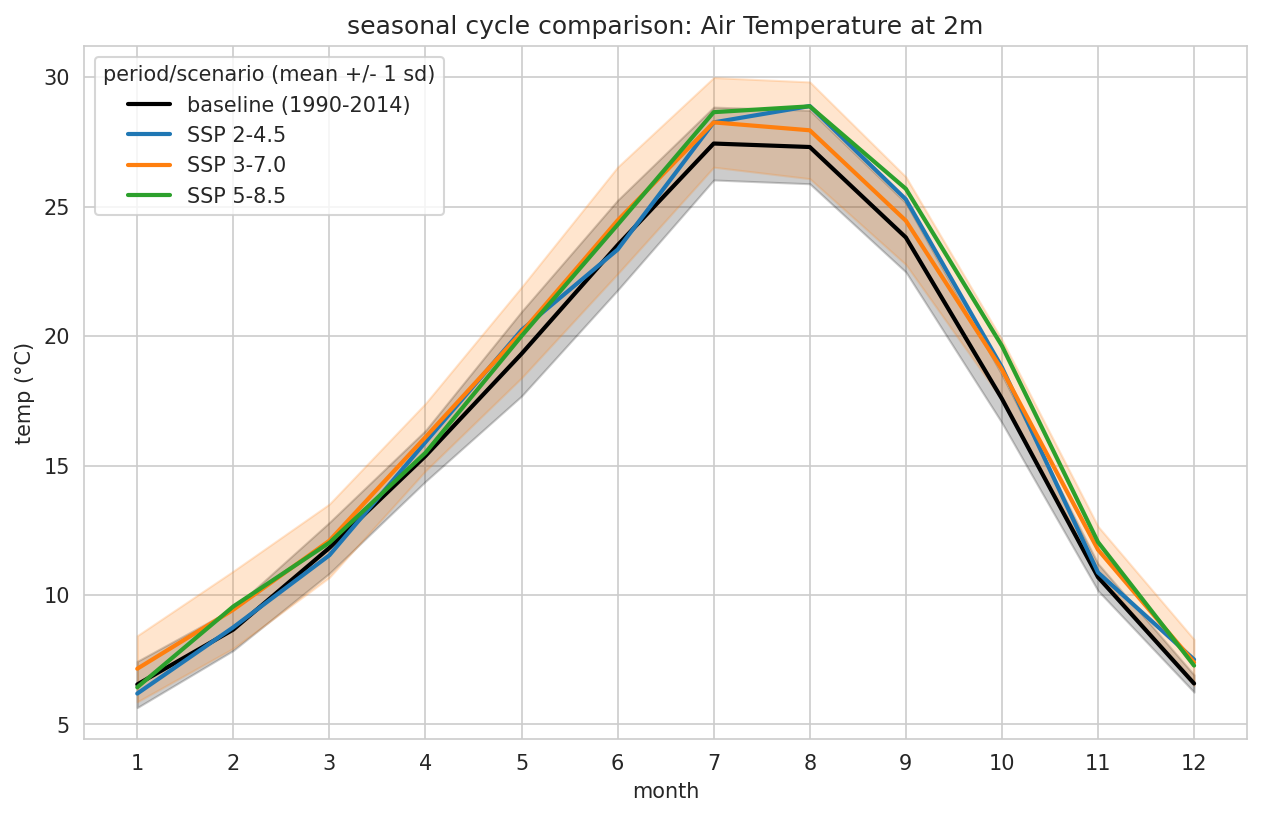

In [22]:
if "temp" not in mojaveSpatialAverageMonthlyDictionary:
    print("no mojave temp data in monthly averages dictionary.")
else:
    print("plotting mojave seasonal cycle comparison for air temperature at 2m...")
    plotSeasonalComparison(mojaveSpatialAverageMonthlyDictionary, "temp")

In [23]:
diagnosticDataDictionary = {}

if mojaveLatitudeSlice is None or mojaveLongitudeSlice is None:
    print("err: mojave slices not defined")
else:
    scenariosToUse = testScenariosList
    print(f"load mojave diagnostic data (monthly, {dataSpatialResolution}, {diagnosticAnalysisTimeSpan})...")
    for key, variableName in analysisVariablesDictionary.items():
        print(f"retrieving {key}...")
        try:
            data = get_data(
                variable=variableName,
                resolution=dataSpatialResolution,
                timescale="monthly",
                scenario=scenariosToUse,
                time_slice=diagnosticAnalysisTimeSpan,
                latitude=mojaveLatitudeSlice,
                longitude=mojaveLongitudeSlice
            )
            if data is not None and data.time.size > 0:
                data.name = key
                diagnosticDataDictionary[key] = data
                print(f"success dims: {data.dims}")
            else:
                print(f"no data for {key}")
        except Exception as e:
            print(f"error retrieving {key}: {e}")

load mojave diagnostic data (monthly, 3 km, (1990, 2030))...
retrieving temp...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

success dims: ('scenario', 'simulation', 'time', 'y', 'x')
retrieving precip...
Input scenario='SSP 1-2.6' is not a valid option.
Closest options: 
- SSP 5-8.5
- SSP 3-7.0
- SSP 2-4.5
Outputting data for scenario='SSP 5-8.5'

success dims: ('scenario', 'simulation', 'time', 'y', 'x')


processing temp...


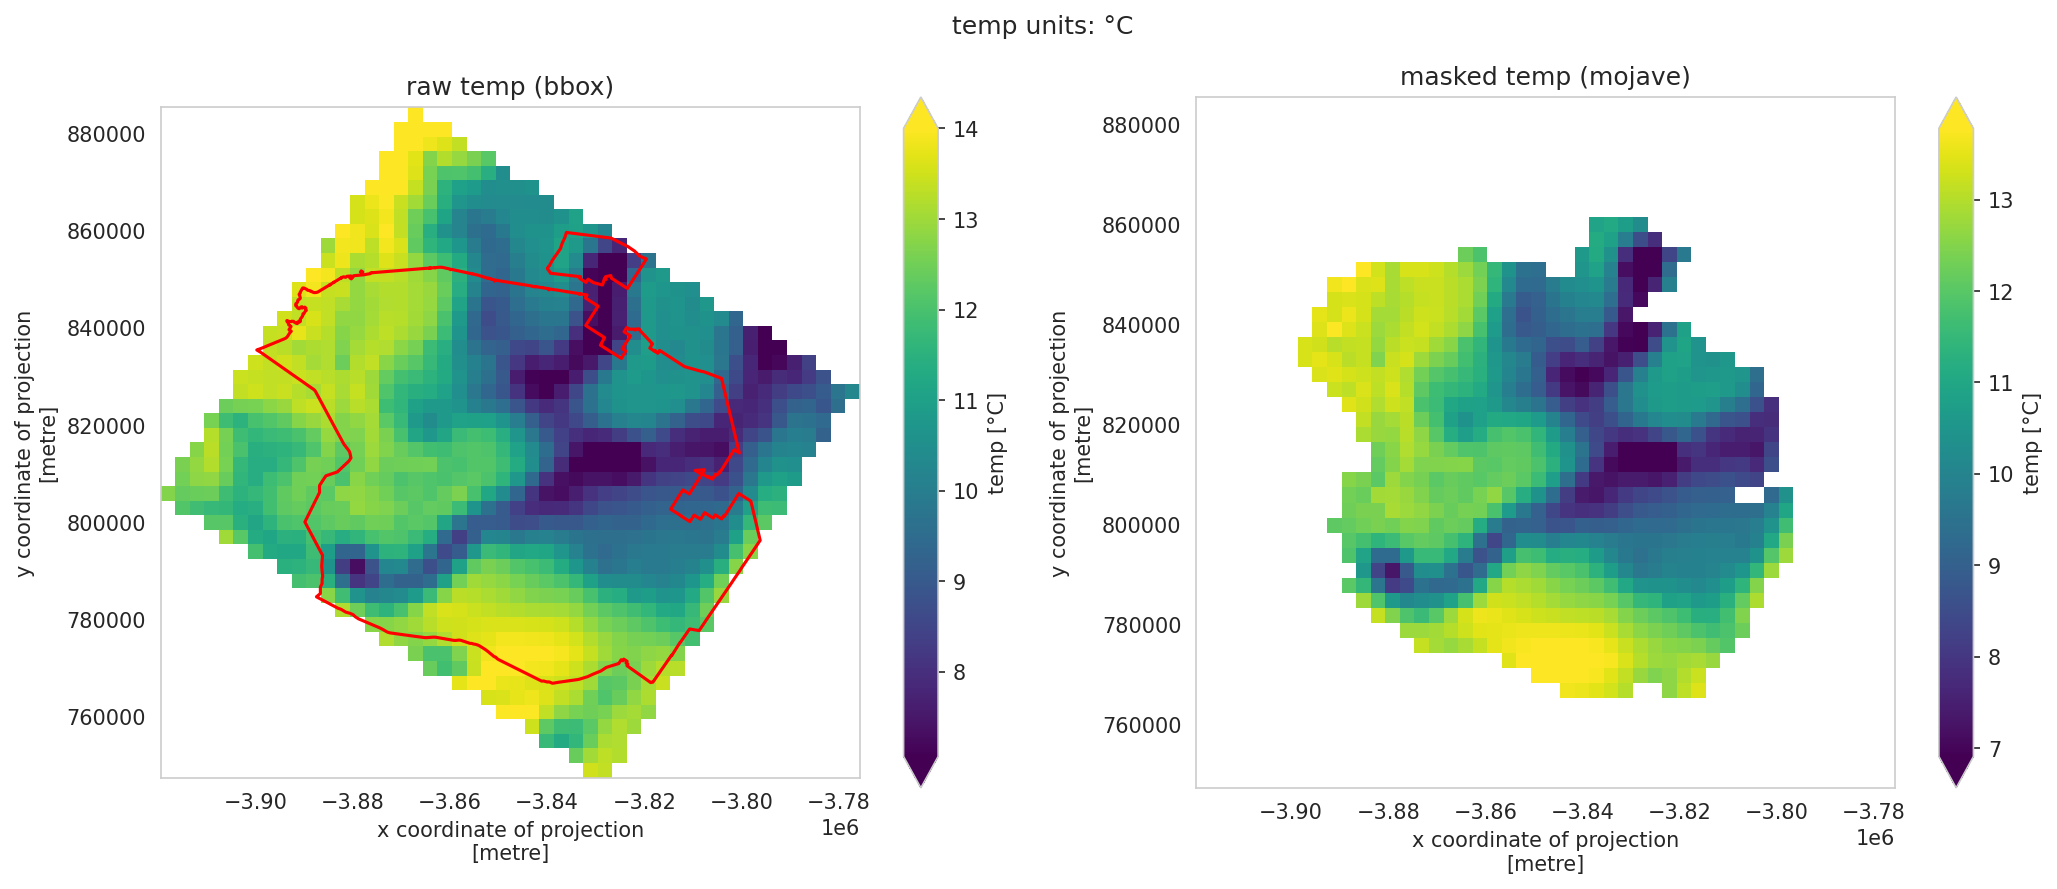

processing precip...


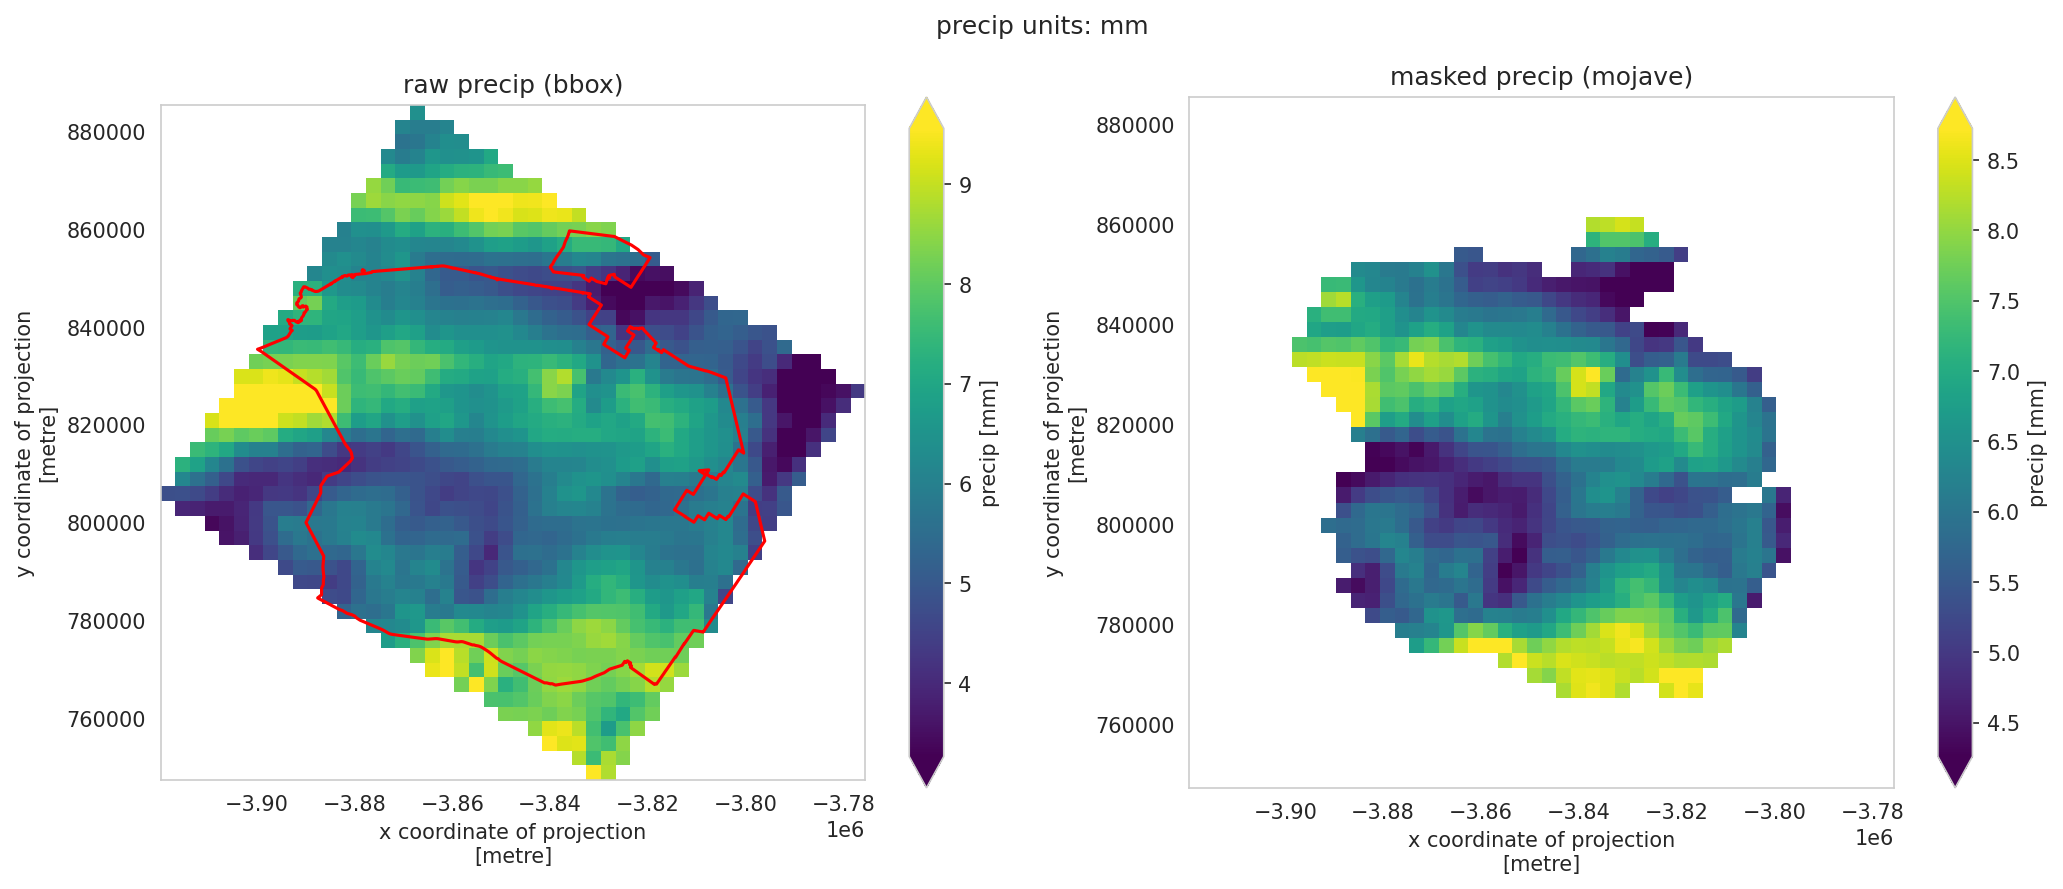

In [24]:
processedDiagnosticData = {}

if not diagnosticDataDictionary:
    print("no diagnostic data loaded")
else:
    for key, data in diagnosticDataDictionary.items():
        print(f"processing {key}...")
        dataWithConvertedUnits = convertDataUnits(data, key)

        if mojaveBoundaryWgs84 is not None:
            maskedDataArray = maskDataArrayToBoundary(dataWithConvertedUnits, mojaveBoundaryWgs84)
        else:
            maskedDataArray = dataWithConvertedUnits

        if maskedDataArray is not None:
            maskedDataArray.name = key
            processedDiagnosticData[key] = maskedDataArray

        if maskedDataArray is not None:
            try:
                selectionKwargs = {"time": 0}
                if "simulation" in dataWithConvertedUnits.dims:
                    selectionKwargs["simulation"] = 0

                sampleRawData = dataWithConvertedUnits.isel(**selectionKwargs).squeeze(drop=True)
                sampleMaskedData = maskedDataArray.isel(**selectionKwargs).squeeze(drop=True)

                if hasattr(sampleRawData, "load"):
                    sampleRawData.load()
                if hasattr(sampleMaskedData, "load"):
                    sampleMaskedData.load()

                fig, axes = plt.subplots(1, 2, figsize=(14, 6))
                sampleRawData.plot(ax=axes[0], robust=True)
                axes[0].set_title(f"raw {key} (bbox)")
                sampleMaskedData.plot(ax=axes[1], robust=True)
                axes[1].set_title(f"masked {key} (mojave)")

                if mojaveBoundaryWgs84 is not None:
                    dataCrs = dataWithConvertedUnits.rio.crs
                    if dataCrs:
                        try:
                            boundaryNativeCrs = mojaveBoundaryWgs84.to_crs(dataCrs)
                            boundaryNativeCrs.boundary.plot(ax=axes[0], color="red", linewidth=1.5)
                        except Exception:
                            pass

                plt.suptitle(f"{key} units: {maskedDataArray.attrs.get('units')}")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"plot fail {key}: {e}")

In [25]:
spatialWeightsDictionary = {}

if not processedDiagnosticData:
    print("no processed data")
else:
    for key, maskedData in processedDiagnosticData.items():
        w = diagnoseSpatialWeights(maskedData)
        spatialWeightsDictionary[key] = w

In [26]:
for key, data in processedDiagnosticData.items():
    checkDataQuality(data, key)

performing data quality checks on temp (first year subset)
nan check: 137856 nans found.
infinity check: 0 infinite values found.
value range: min -4.7520, max 37.5923 °C
performing data quality checks on precip (first year subset)
nan check: 137856 nans found.
infinity check: 0 infinite values found.
value range: min 0.0000, max 401.3715 mm


In [27]:
spatialAverageDataDictionary = {}

for key, maskedData in processedDiagnosticData.items():
    w = spatialWeightsDictionary.get(key, None)
    avg = calculateSpatialAverage(maskedData, w)
    if avg is not None:
        avg.name = key
        spatialAverageDataDictionary[key] = avg

In [28]:
annualDataDictionary = {}

for key, avg in spatialAverageDataDictionary.items():
    ann = aggregateDataAnnually(avg, key)
    if ann is not None:
        ann.name = key
        annualDataDictionary[key] = ann

aggregate data annually for temp
aggregate data annually for precip


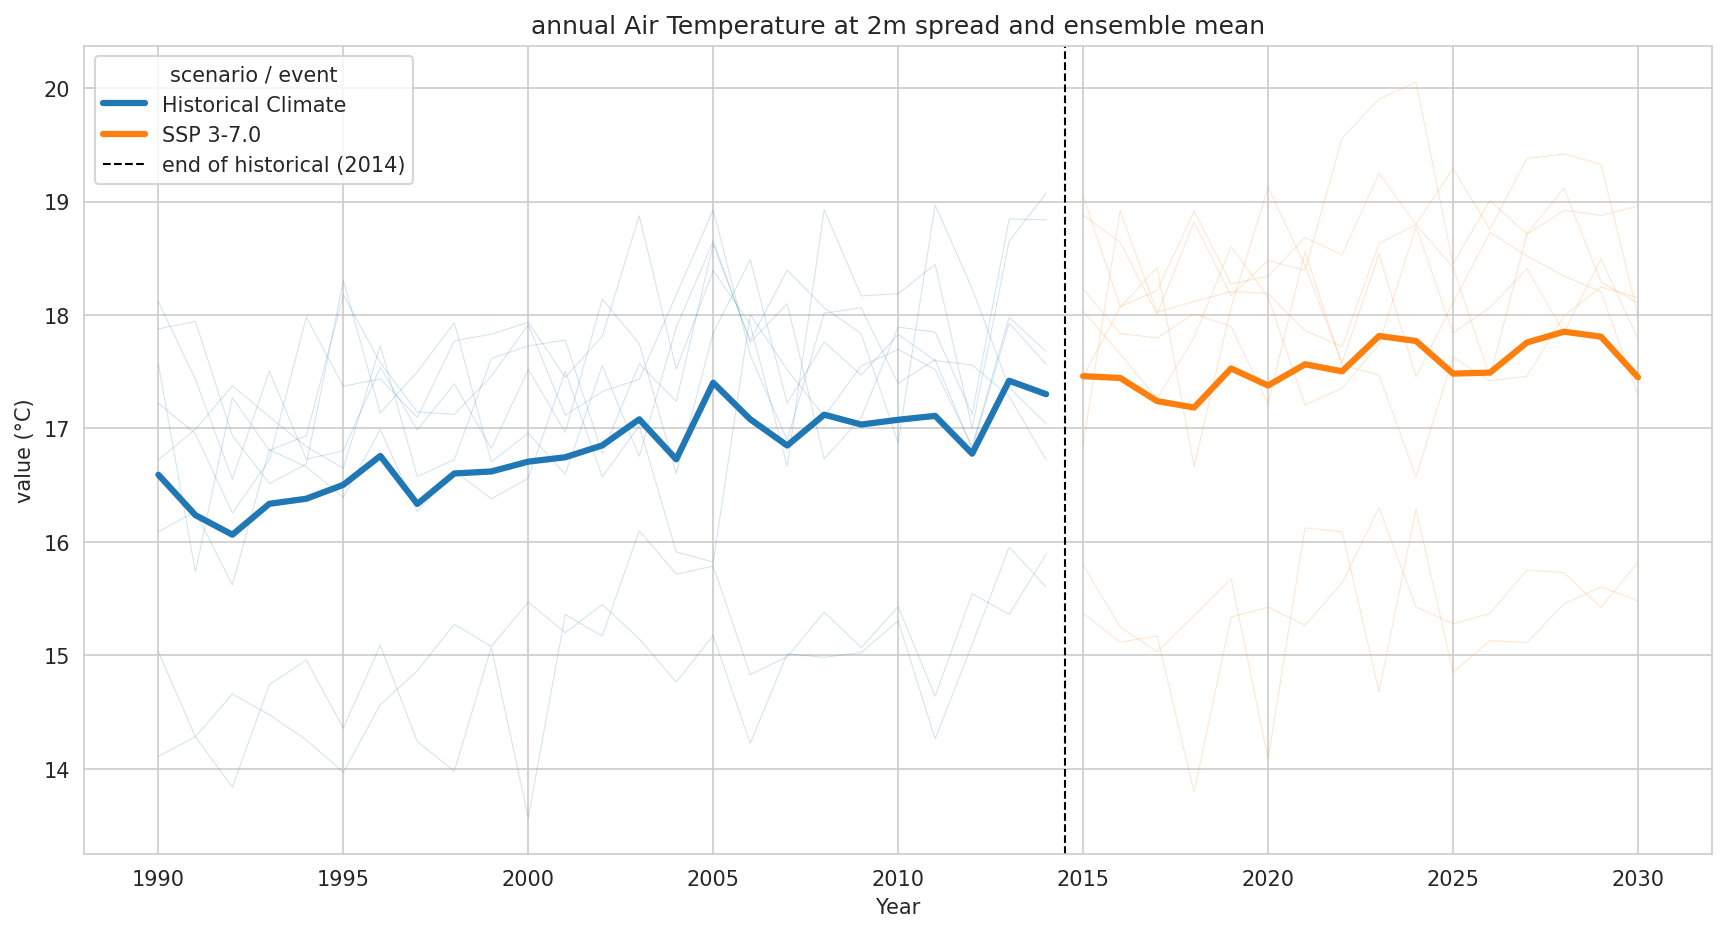

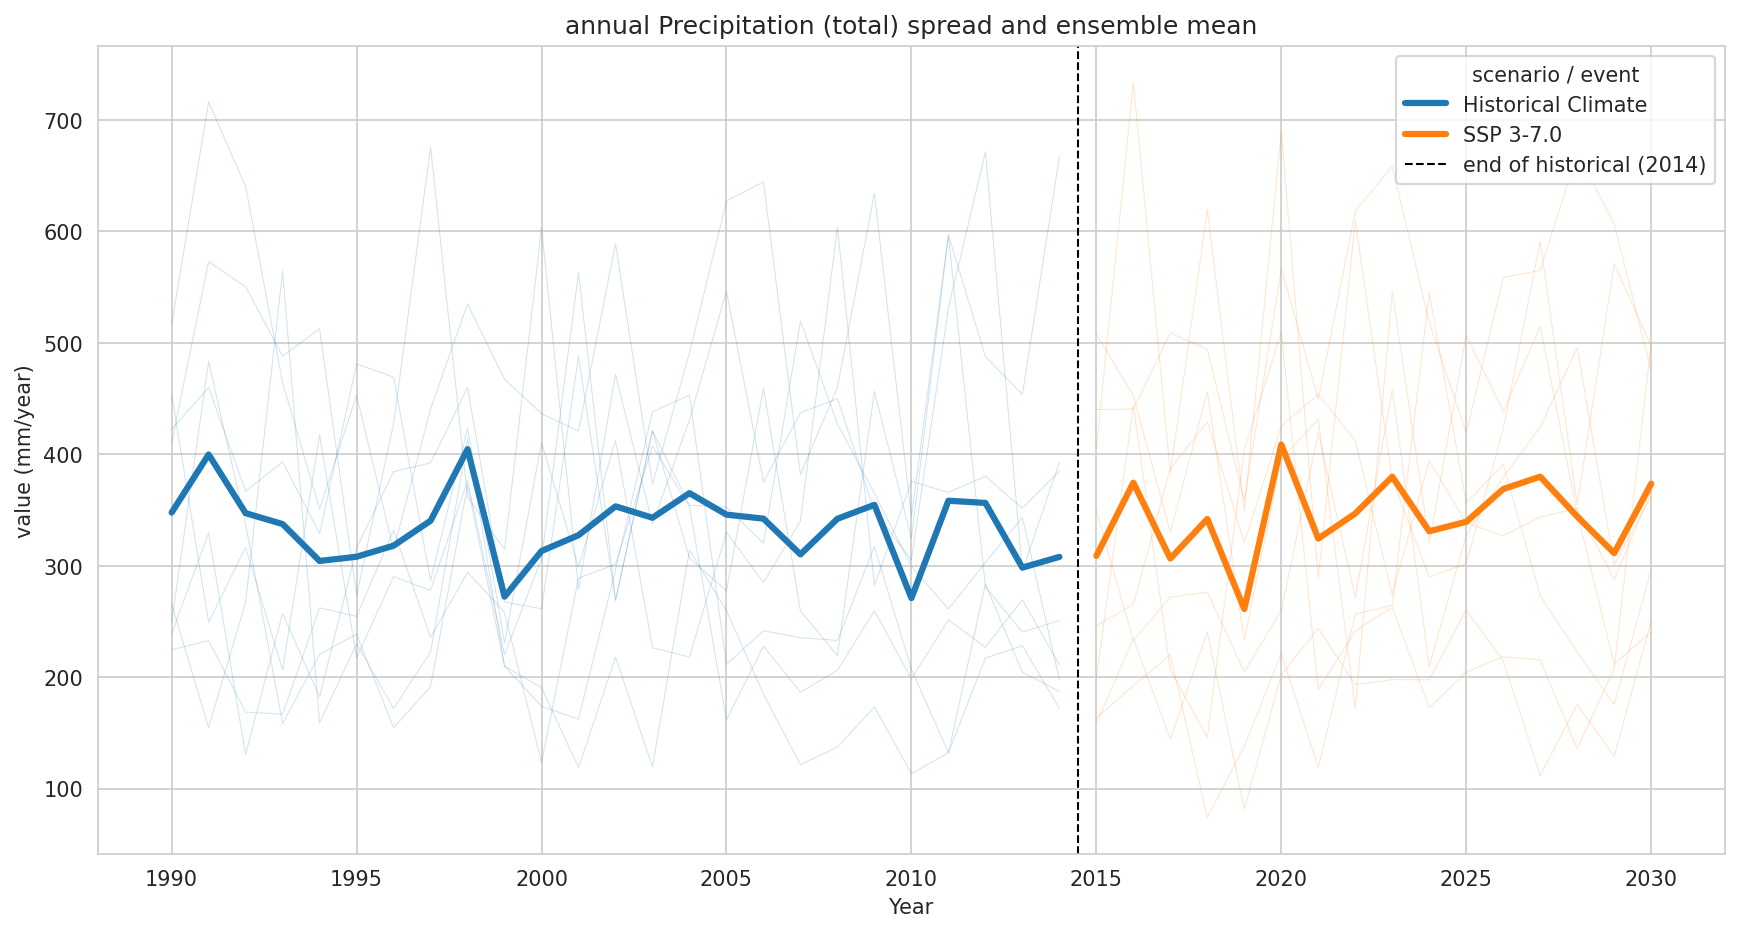

In [29]:
for key, ann in annualDataDictionary.items():
    plotAnnualSpread(ann, key)

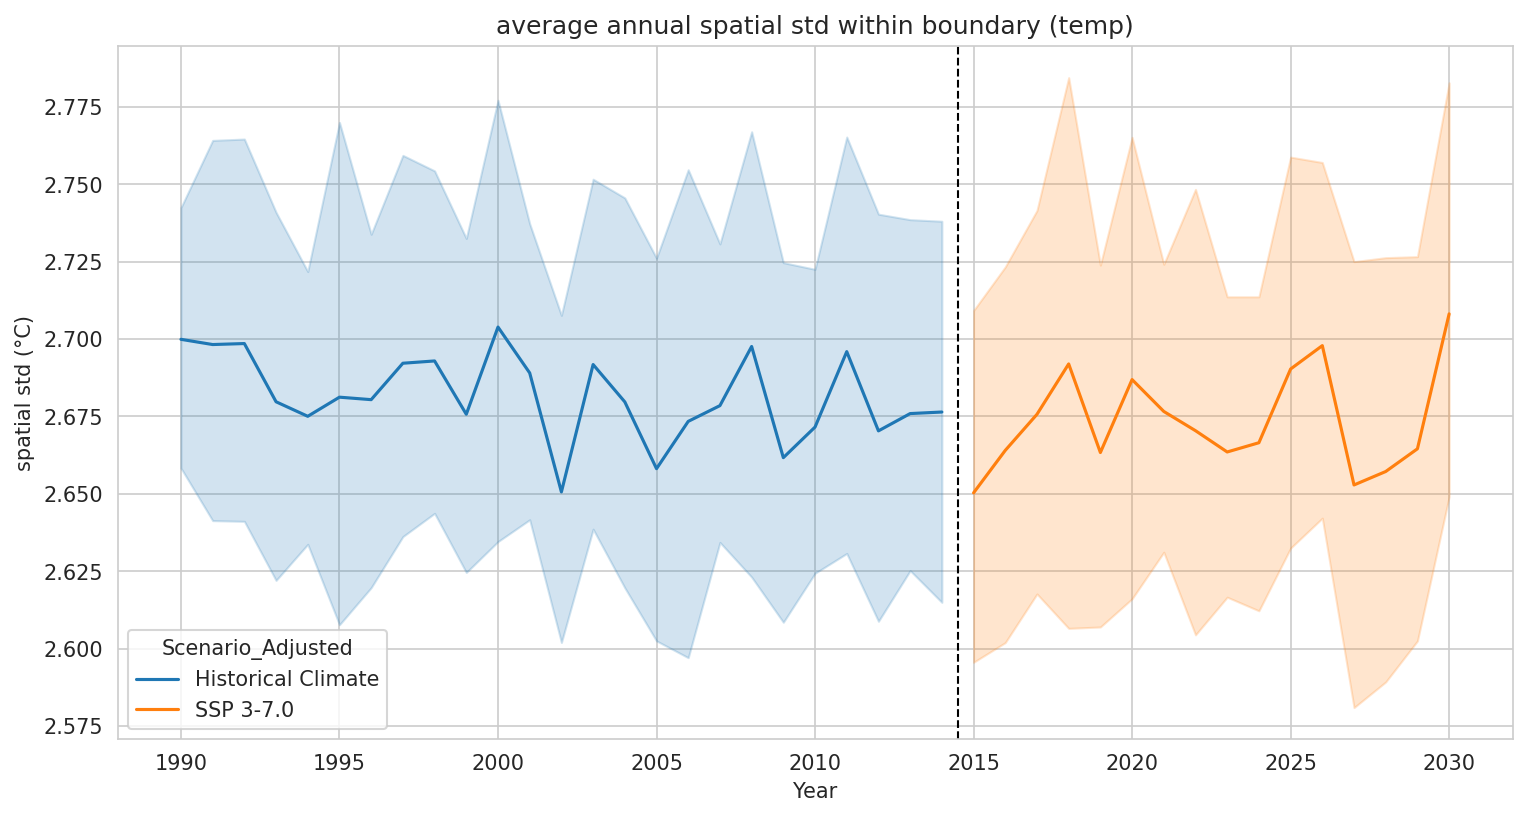

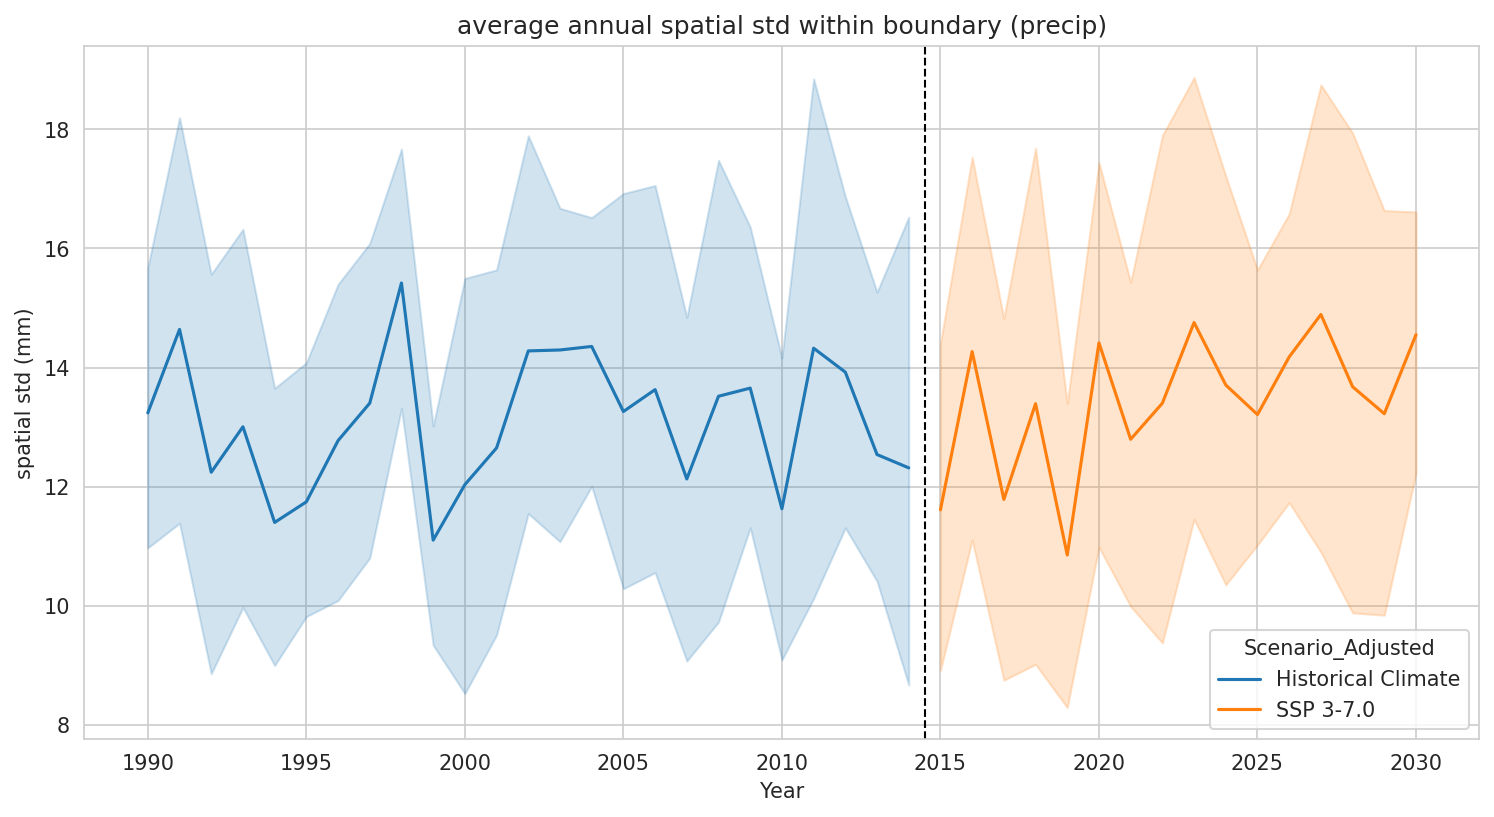

In [31]:
for key, maskedData in processedDiagnosticData.items():
    analyzeSpatialVariability(maskedData, key)

In [43]:
plt.close("all")

if "processedDiagnosticData" not in globals():
    raise NameError("processedDiagnosticData not found")

print("processedDiagnosticData keys:", list(processedDiagnosticData.keys()))

processedDiagnosticData keys: ['temp', 'precip']



variable: temp


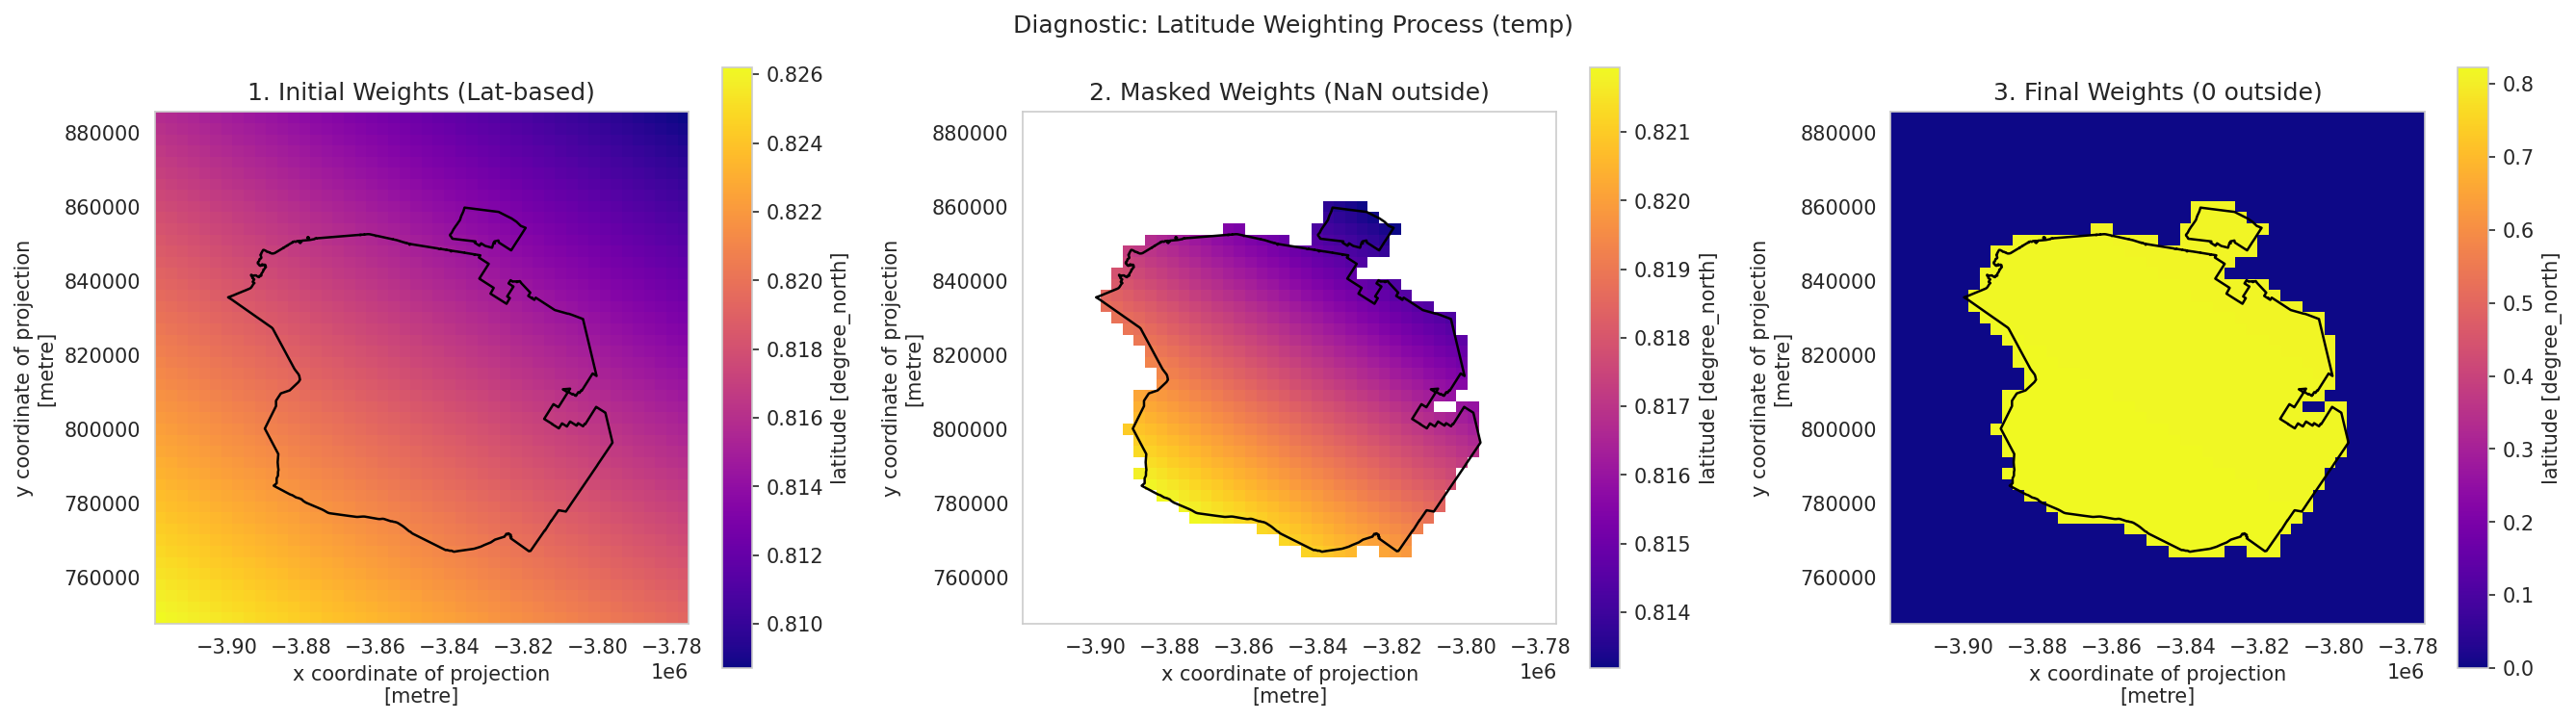


variable: precip


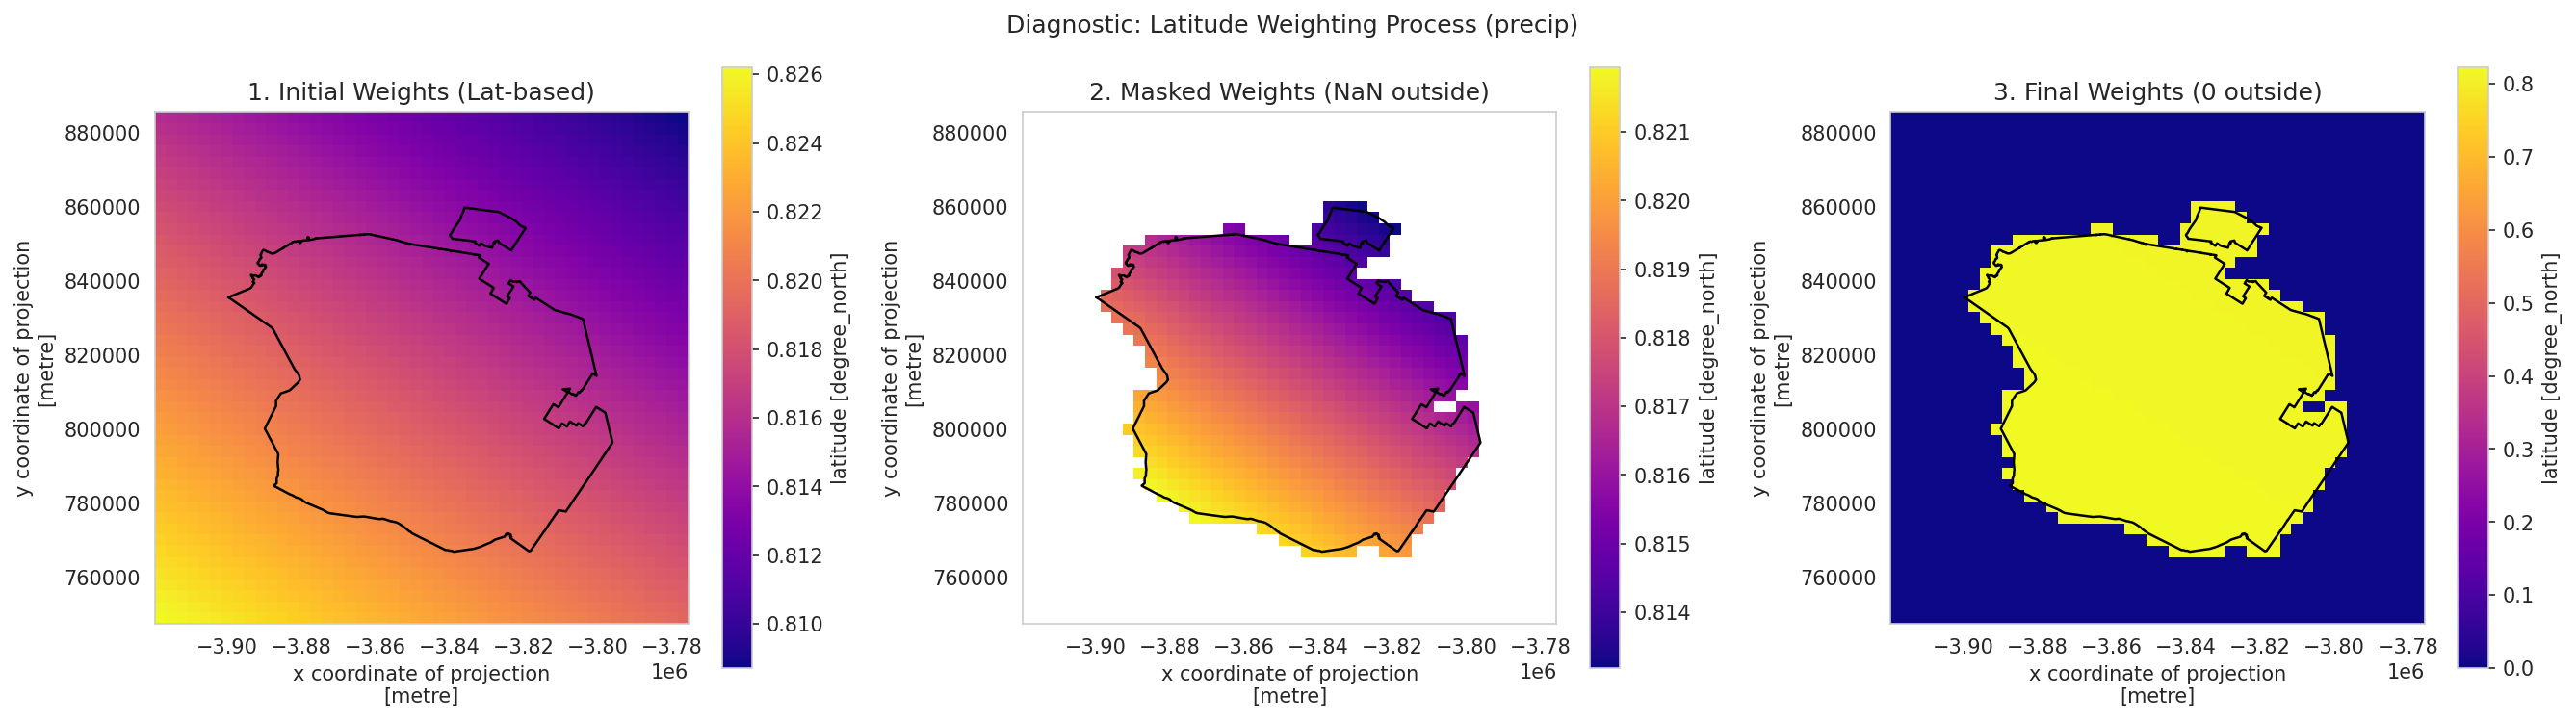

In [44]:
spatialWeightsDictionary = {}

for key, data in processedDiagnosticData.items():
    print("\nvariable:", key)

    if data is None:
        spatialWeightsDictionary[key] = None
        print("data is None")
        continue

    if "lat" not in data.coords:
        spatialWeightsDictionary[key] = None
        print("lat coordinate missing")
        continue

    weightsInitial = np.cos(np.deg2rad(data["lat"]))

    yDim = data.rio.y_dim if hasattr(data, "rio") and data.rio.y_dim is not None else "y"
    xDim = data.rio.x_dim if hasattr(data, "rio") and data.rio.x_dim is not None else "x"
    nonSpatialDims = [d for d in data.dims if d not in [yDim, xDim]]

    if nonSpatialDims:
        isInsideBoundary = data.notnull().any(dim=nonSpatialDims)
    else:
        isInsideBoundary = data.notnull()

    weightsMasked = weightsInitial.where(isInsideBoundary)
    weightsFinal = weightsMasked.fillna(0)

    def getPlotSlice(arr):
        if hasattr(arr, "dims"):
            for dim in ["scenario", "simulation", "time"]:
                if dim in arr.dims:
                    arr = arr.isel({dim: 0}, drop=True)
        return arr

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    getPlotSlice(weightsInitial).plot(ax=axes[0], cmap="plasma")
    axes[0].set_title("1. Initial Weights (Lat-based)")

    getPlotSlice(weightsMasked).plot(ax=axes[1], cmap="plasma")
    axes[1].set_title("2. Masked Weights (NaN outside)")

    getPlotSlice(weightsFinal).plot(ax=axes[2], cmap="plasma")
    axes[2].set_title("3. Final Weights (0 outside)")

    if "mojaveBoundaryWgs84" in globals() and mojaveBoundaryWgs84 is not None:
        try:
            dataCrs = data.rio.crs if hasattr(data, "rio") else None
            boundaryNative = mojaveBoundaryWgs84.to_crs(dataCrs) if dataCrs is not None else mojaveBoundaryWgs84
            for ax in axes:
                boundaryNative.boundary.plot(ax=ax, color="black", linewidth=1.2)
        except Exception as e:
            print("boundary overlay failed:", e)

    plt.suptitle(f"Diagnostic: Latitude Weighting Process ({key})")
    plt.tight_layout()
    plt.show()

    spatialWeightsDictionary[key] = weightsFinal